# **Ekstrapolacyjna analiza danych - projekt blok 2**
***Projekt analizujący dane w celu wyszukania czynników wpływających na rozwój depresji. Przygotowanie modelu predykcyjnego.***
---



---


## **Import niezbędnych bibliotek**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import expit



---


## **Wczytanie danych**

In [91]:
df = pd.read_csv('27521-0001-Data.tsv', sep='\t')
print(df.head())

   CASEID  QUESTID  CIGEVER  CIGOFRSM  CIGWILYR  CIGTRY  CIGYFU  CIGMFU  \
0       1  2000033        1        99        99      18    9999      99   
1       2  2000140        1        99        99      13    9999      99   
2       3  2000202        1        99        99      28    9999      99   
3       4  2000220        1        99        99      12    9999      99   
4       5  2000257        1        99        99      12    9999      99   

   CIGREC  CIG30USE  ...  LARCENY  MTRTHEFT  FRAUD  PROPCRME  DRUG  DRUGSALE  \
0       1         3  ...        0         0      0         0     0         0   
1       4        93  ...        0         0      0         0     0         0   
2       4        93  ...        0         0      0         0     0         0   
3       4        93  ...        0         0      0         0     0         0   
4       4        93  ...        0         0      0         0     0         0   

   ALLARRST  SAXMDE  MDEGT12M  SAXMDEGT  
0         0       0       



---


## **Wstępna analiza danych, regresja**

Poniżej przeprowadzono wstępną analizę danych, obejmującą korelację, regresję logistyczną oraz wizualizację rozkładu depresji w grupach wiekowych i płci.

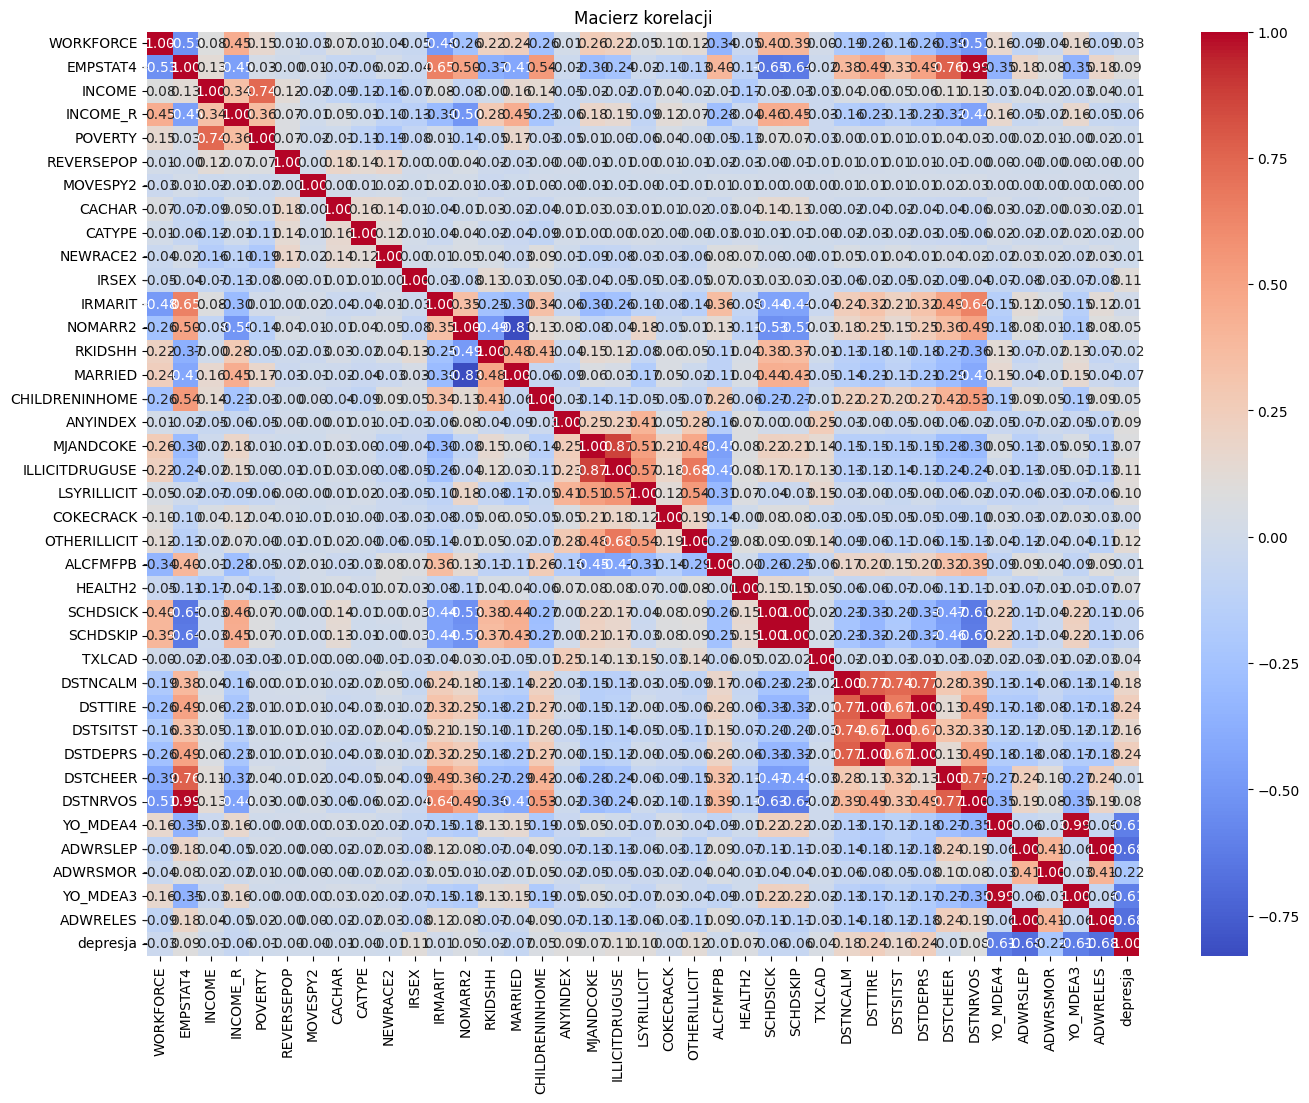

Optimization terminated successfully.
         Current function value: 0.331749
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55598
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                0.006143
Time:                        18:16:04   Log-Likelihood:                -18446.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                 3.716e-49
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9809      0.045    -44.228      0.000      -2.069      -1.893
INCOME         0.0299      0.

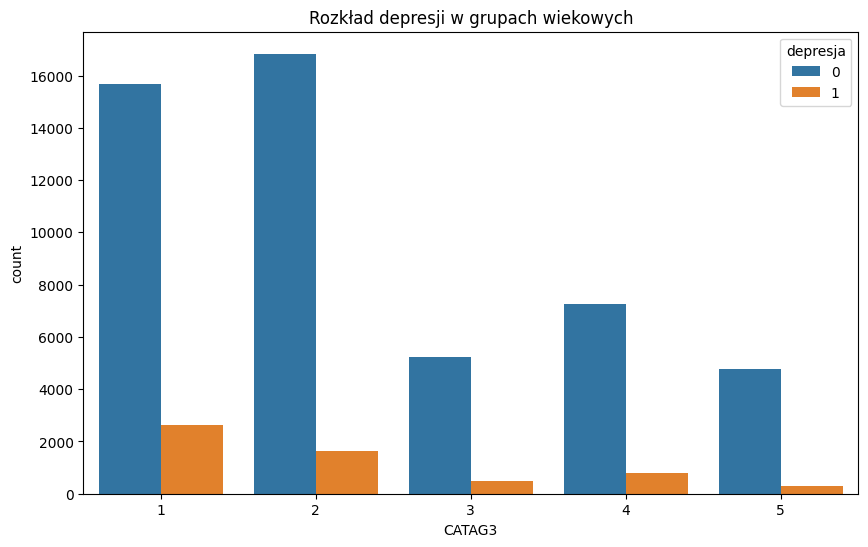

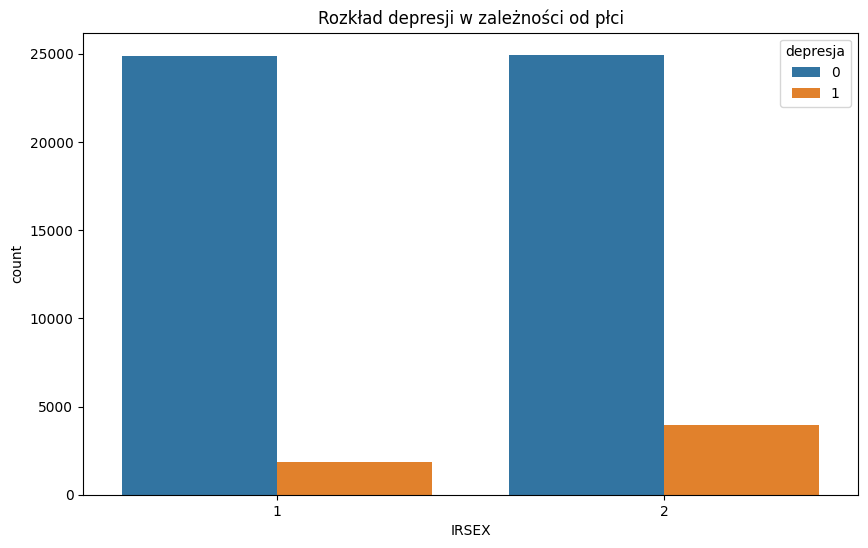

T-statystyka: -8.41
P-wartość: 0.000


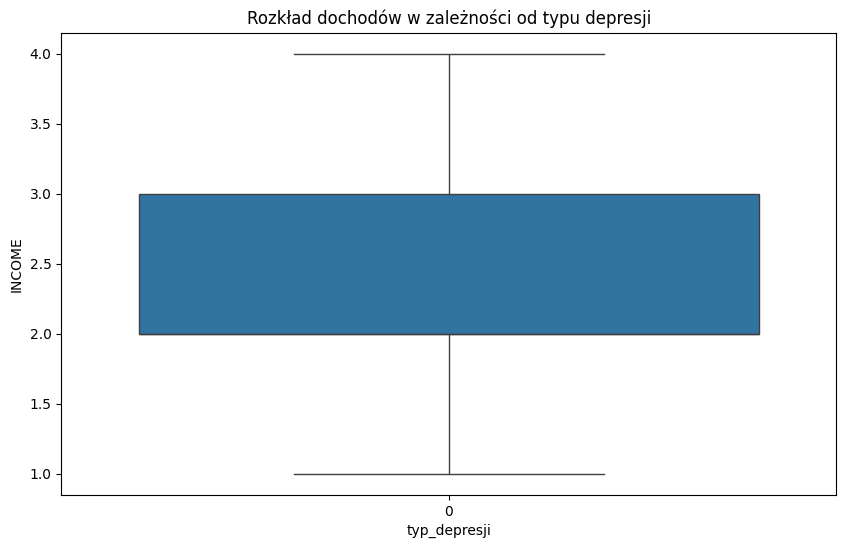

In [92]:
# Wybór zmiennych do analizy
zmienne = {
    'praca': ['WORKFORCE', 'EMPSTAT4', 'INCOME', 'INCOME_R', 'POVERTY'],
    'srodowisko': ['REVERSEPOP', 'MOVESPY2', 'CACHAR', 'CATYPE'],
    'rasa': ['NEWRACE2'],
    'płeć': ['IRSEX'],
    'rodzina': ['IRMARIT', 'NOMARR2', 'RKIDSHH', 'MARRIED', 'CHILDRENINHOME'],
    'uzaleznienia': ['ANYINDEX', 'MJANDCOKE', 'ILLICITDRUGUSE',
                     'LSYRILLICIT', 'COKECRACK', 'OTHERILLICIT', 'ALCFMFPB'],
    'zdrowie': ['HEALTH2', 'SCHDSICK', 'SCHDSKIP', 'TXLCAD', 'DSTNCALM',
                'DSTTIRE', 'DSTSITST', 'DSTDEPRS', 'DSTCHEER', 'DSTNRVOS',
                'YO_MDEA4', 'ADWRSLEP', 'ADWRSMOR', 'YO_MDEA3', 'ADWRELES']
}

'''
Utworzenie zmiennej depresja (0 - brak depresji, 1 - depresja)
na podstawie DEPRESSIONINDEX
'''
prog_depresji = 4
df['depresja'] = (df['DEPRESSIONINDEX'] > prog_depresji).astype(int)

# Analiza wpływu czynników na depresję
# 1. Korelacja
korelacje = df[zmienne['praca'] + zmienne['srodowisko'] + zmienne['rasa'] +
               zmienne['płeć'] + zmienne['rodzina'] + zmienne['uzaleznienia'] +
               zmienne['zdrowie'] + ['depresja']].corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(16, 12))
sns.heatmap(korelacje, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()

# 2. Regresja logistyczna (przykład dla czynników pracy)
model = smf.logit("depresja ~ INCOME + INCOME_R + POVERTY", data=df).fit()
print(model.summary())

# Analiza w podziale na grupy wiekowe i płeć
# 1. Wizualizacja rozkładu depresji w grupach wiekowych i płci
plt.figure(figsize=(10, 6))
sns.countplot(x='CATAG3', hue='depresja', data=df, hue_order=[0, 1])
plt.title('Rozkład depresji w grupach wiekowych')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='IRSEX', hue='depresja', data=df, hue_order=[0, 1])
plt.title('Rozkład depresji w zależności od płci')
plt.show()

# 2. Analiza różnic w występowaniu depresji między grupami
grupa_mezczyzn = df[df['IRSEX'] == 1]['DEPRESSIONINDEX']
grupa_kobiet = df[df['IRSEX'] == 2]['DEPRESSIONINDEX']
t_stat, p_value = ttest_ind(grupa_mezczyzn, grupa_kobiet)
print(f'T-statystyka: {t_stat:.2f}')
print(f'P-wartość: {p_value:.3f}')

# Analiza w podziale na typ depresji
# 1. Utworzenie zmiennej typ_depresji (0 - niesomatyczna, 1 - somatyczna)
df['typ_depresji'] = (
    (df['YO_MDEA3'] == 1) & (df['YO_MDEA4'] == 1) &
    (df['ADWRELES'] == 1) & (df['ADWRSLEP'] == 1)
).astype(int)

# 2. Analiza różnic w występowaniu czynników między typami depresji
plt.figure(figsize=(10, 6))
sns.boxplot(x='typ_depresji', y='INCOME', data=df)
plt.title('Rozkład dochodów w zależności od typu depresji')
plt.show()

* `ANYINDEX` (wskaźnik uzależnienia od narkotyków) jest dość silnie skorelowany z depresja (0.29), co sugeruje, że osoby uzależnione są bardziej narażone na depresję.

* `HEALTH2` (samoocena stanu zdrowia) jest umiarkowanie skorelowana z depresja (-0.36), co oznacza, że osoby z gorszym stanem zdrowia częściej doświadczają depresji.

* Zmienne związane z pracą (`INCOME`, `INCOME_R`, `POVERTY`) mają słabe korelacje z depresja.

* Niektóre zmienne są silnie skorelowane ze sobą, np. `INCOME` i `INCOME_R` (0.76), co jest logiczne, bo dochód rodziny i dochód własny są powiązane.

Wyniki regresji logistycznej potwierdzają, że `INCOME_R` (dochód własny) ma istotny wpływ na depresję, a `INCOME` i `POVERTY` nie są istotne w tym modelu.

1. Pierwszy wykres pokazuje rozkład depresji w grupach wiekowych. Widać, że depresja występuje częściej w grupie wiekowej 18-25 lat.

2. Drugi wykres pokazuje rozkład depresji w zależności od płci. Wygląda na to, że depresja jest częściej diagnozowana u kobiet.

3. Trzeci wykres przedstawia rozkład dochodów w zależności od typu depresji. Wykres ten jest "dziwny", ponieważ pokazuje tylko jedną grupę. Prawdopodobnie wynika to z tego, że w Twoich danych jest bardzo mało osób z depresją somatyczną (zgodnie z definicją, którą zastosowałeś w kodzie).






---

## **Utworzenie zmiennych `depresja` oraz `typ_depresji`**

[0 1]


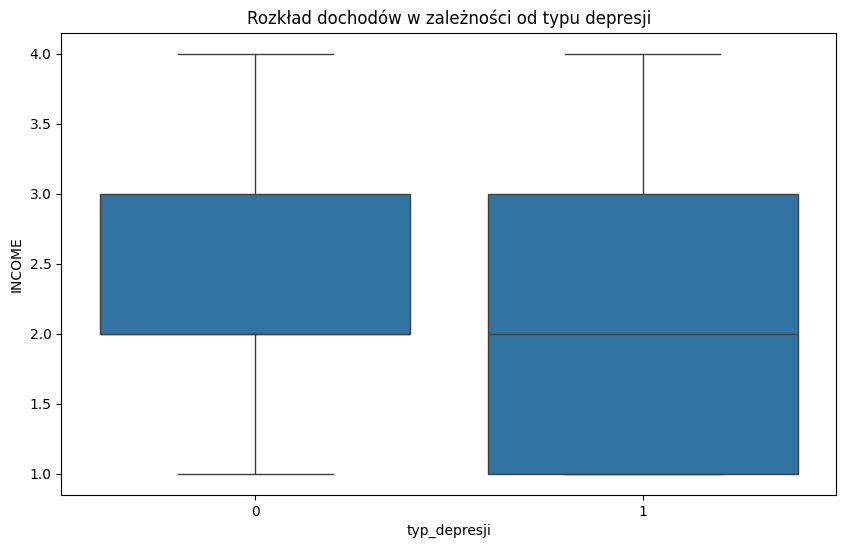

In [93]:
prog_depresji = 4
df['depresja'] = (df['DEPRESSIONINDEX'] > prog_depresji).astype(int)

df['typ_depresji'] = (
    (df['YO_MDEA3'] == 1) & (df['ADWRELES'] == 1) |
    (df['YO_MDEA4'] == 1) & (df['ADWRSLEP'] == 1) |
    (df['ADWRENRG'] == 1)
).astype(int)

print(df['typ_depresji'].unique())

plt.figure(figsize=(10, 6))
sns.boxplot(x='typ_depresji', y='INCOME', data=df)
plt.title('Rozkład dochodów w zależności od typu depresji')
plt.show()

Zmodyfikowano definicję depresji somatycznej, tak aby uwzględnić osoby, u których występuje co najmniej jeden z objawów somatycznych: zaburzenia apetytu, problemy ze snem lub zmęczenie.

W ten sposób, zwiększono liczbę osób w grupie z depresją somatyczną, co pozwoli na przeprowadzenie bardziej miarodajnej analizy w dalszej części.



Następnie, zgodnie z instrukcją, wybrano 6 istotnych czynników, które mają istotny wpływ na depresję.

Do analizy wybrano poniżej widoczne czynniki z różnych kategorii, takich jak praca, środowisko, rasa, płeć, rodzina, uzależnienia i zdrowie, aby badanie było jak najbardziej zróżnicowane.

Podczas wyboru czynników, wzięto pod uwagę siłę i kierunek korelacji z depresją, a także na potencjalne zależności między samymi czynnikami.

Po wyborze czynników, dokonana zostanie analiza i jej wpływ na depresję w zależności od grupy wiekowej i płci. Wykorzystane zostaną poznane metody oceny istotności, takie jak regresja logistyczna z interakcjami, testy statystyczne i wizualizację.



---


## **Faza I - analiza czynnikowa i eksploracja**



---

### **Analiza wybranych czynników i ich korelacja z ryzykiem depresji**


#### Analiza czynnika `INCOME_R` (dochód własny).

Optimization terminated successfully.
         Current function value: 0.323378
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.03122
Time:                        18:16:06   Log-Likelihood:                -17980.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                5.509e-246
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.4583      0.185    -18.705      0.000      -3.821      -3.

<Figure size 1000x600 with 0 Axes>

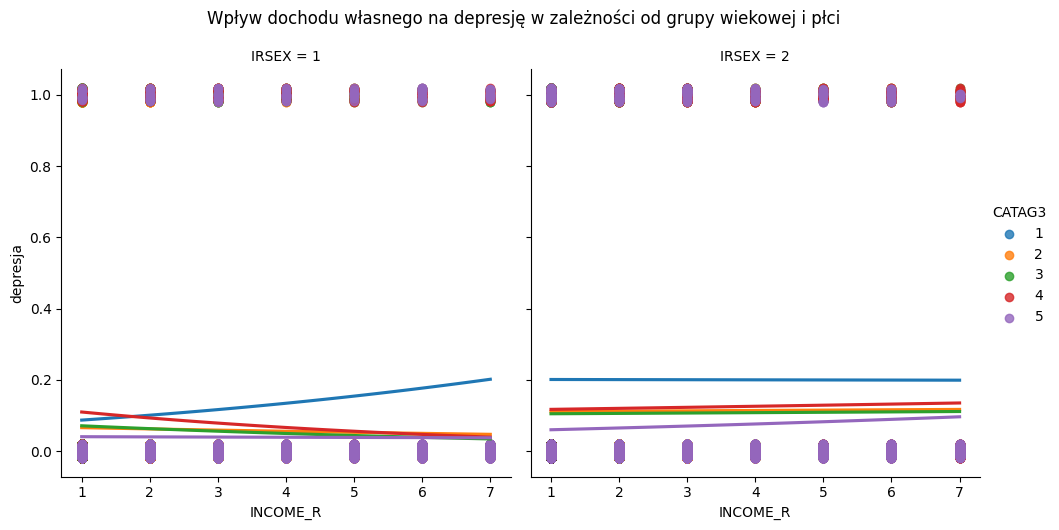

In [94]:
# Regresja logistyczna z interakcjami
model = smf.logit(
    "depresja ~ INCOME_R * CATAG3 * IRSEX", data=df
).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='INCOME_R',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ dochodu własnego na depresję w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Wyniki regresji logistycznej pokazują, że interakcja między `INCOME_R` (dochód własny), `CATAG3` (grupa wiekowa) i `IRSEX` (płeć) jest istotna statystycznie (p-wartość < 0.05). Oznacza to, że wpływ dochodu własnego na depresję różni się w zależności od wieku i płci.

Współczynniki dla interakcji:

* `INCOME_R:CATAG3` (-0.0650) sugeruje, że w starszych grupach wiekowych wpływ dochodu własnego na depresję jest słabszy.

* `INCOME_R:IRSEX` (-0.1127) wskazuje, że u mężczyzn dochód własny może mieć mniejszy wpływ na depresję niż u kobiet.

* `CATAG3:IRSEX` (-0.2994) pokazuje, że płeć może różnicować wpływ wieku na depresję.

* `INCOME_R:CATAG3:IRSEX` (0.0710) - najważniejszy wynik - sugeruje, że zależność między dochodem własnym a depresją jest modyfikowana zarówno przez wiek, jak i płeć.

Wykresy wizualizują wpływ dochodu własnego na depresję w podziale na płeć (`IRSEX` = 1 dla mężczyzn, `IRSEX` = 2 dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji są dość płaskie, co sugeruje, że dochód własny ma niewielki wpływ na prawdopodobieństwo depresji u mężczyzn, niezależnie od wieku.
* Kobiety: Linie regresji są bardziej strome, szczególnie dla młodszych grup wiekowych. Wskazuje to, że u kobiet, zwłaszcza młodych, dochód własny może mieć większy wpływ na depresję.

Na podstawie tych wyników można wnioskować, że zależność między dochodem własnym a depresją jest złożona i zależy od wieku i płci. U kobiet, szczególnie młodych, niski dochód własny może zwiększać ryzyko depresji. U mężczyzn ta zależność wydaje się być słabsza.






---
#### Analiza czynnika `ANYINDEX` (wskaźnik uzależnienia od narkotyków)


Optimization terminated successfully.
         Current function value: 0.320364
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.04025
Time:                        18:16:08   Log-Likelihood:                -17813.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.1924      0.183    -17.451      0.000      -3.551      -2.

<Figure size 1000x600 with 0 Axes>

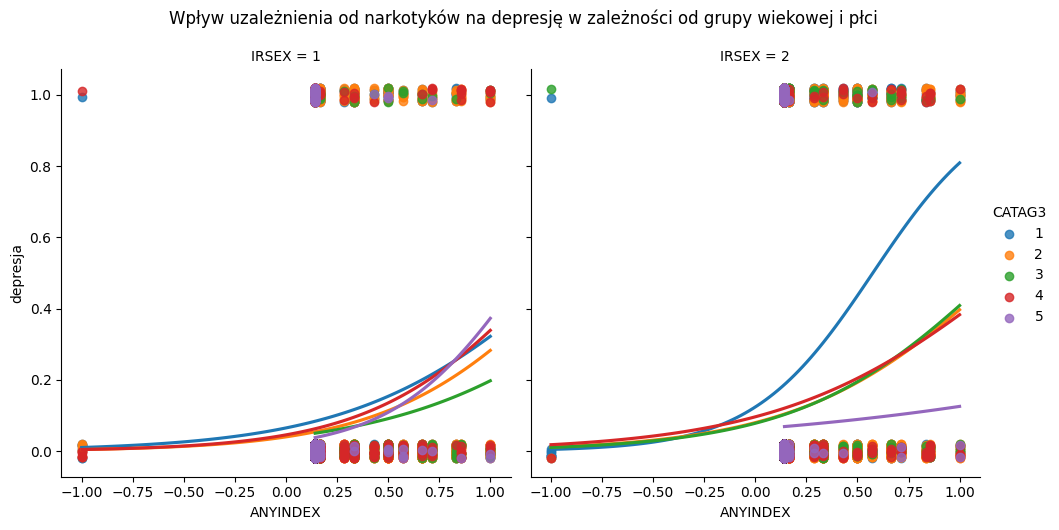

In [95]:
# Regresja logistyczna z interakcjami
model = smf.logit("depresja ~ ANYINDEX * CATAG3 * IRSEX", data=df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='ANYINDEX',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ uzależnienia od narkotyków na depresję w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Zrealizowano regresję logistyczną z interakcjami dla zmiennej `ANYINDEX` (wskaźnik uzależnienia od narkotyków) w zależności od `CATAG3` (grupa wiekowa) i `IRSEX` (płeć). Wyniki pokazują, że interakcja między tymi zmiennymi jest istotna statystycznie (p-wartość < 0.05). Oznacza to, że wpływ uzależnienia od narkotyków na depresję różni się w zależności od wieku i płci.

Zauważyć można następujące współczynniki dla interakcji:

* `ANYINDEX:CATAG3` (1.0811) sugeruje, że w starszych grupach wiekowych wpływ uzależnienia od narkotyków na depresję może być silniejszy.

* `ANYINDEX:IRSEX` (2.0661) wskazuje, że u mężczyzn uzależnienie od narkotyków może mieć większy wpływ na depresję niż u kobiet.

* `CATAG3:IRSEX` (0.0638) - ta interakcja nie jest istotna statystycznie, co oznacza, że płeć może nie różnicować wpływu wieku na depresję.

* `ANYINDEX:CATAG3:IRSEX` (-0.9112) - ta interakcja jest istotna i sugeruje, że zależność między uzależnieniem od narkotyków a depresją jest modyfikowana zarówno przez wiek, jak i płeć.

Na wykresach zwizualizowano wpływ uzależnienia od narkotyków na depresję w podziale na płeć (`IRSEX` = 1 dla mężczyzn, `IRSEX` = 2 dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji wykazują, że wraz ze wzrostem wskaźnika uzależnienia od narkotyków, rośnie prawdopodobieństwo depresji, szczególnie w starszych grupach wiekowych.

* Kobiety: Podobnie jak u mężczyzn, zauważyć można wzrost prawdopodobieństwa depresji wraz ze wzrostem wskaźnika uzależnienia od narkotyków. Jednakże, wpływ ten wydaje się być mniejszy niż u mężczyzn.

Na podstawie tych wyników można wnioskować, że uzależnienie od narkotyków istotnie wpływa na depresję, a siła tego wpływu jest modyfikowana przez wiek i płeć. U mężczyzn, szczególnie w starszych grupach wiekowych, uzależnienie od narkotyków może silniej zwiększać ryzyko depresji.




---

#### Analiza czynnika `HEALTH2` (samoocena stanu zdrowia)

Optimization terminated successfully.
         Current function value: 0.320511
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.03981
Time:                        18:16:10   Log-Likelihood:                -17821.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.5247      0.273    -12.898      0.000      -4.060      -2.989

<Figure size 1000x600 with 0 Axes>

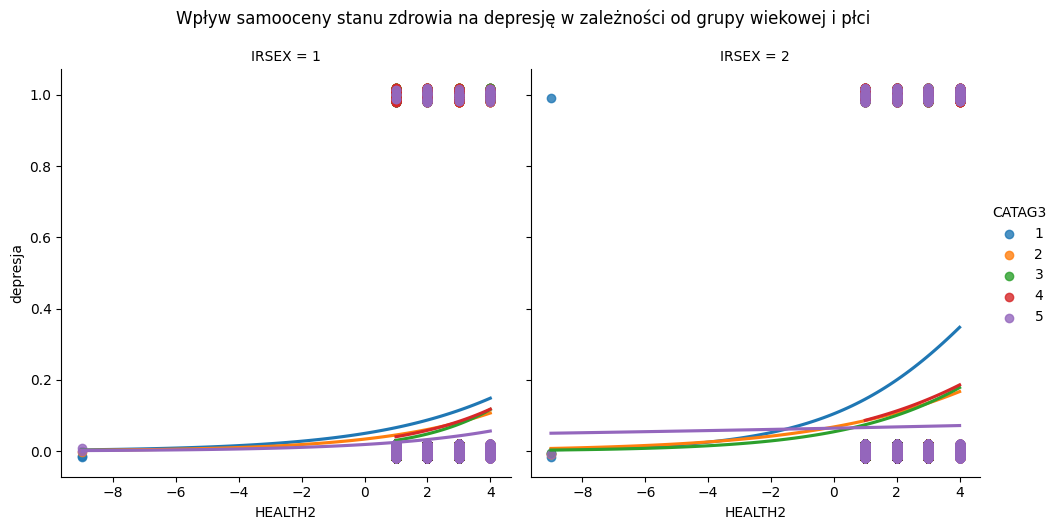

In [96]:
# Regresja logistyczna z interakcjami
model = smf.logit("depresja ~ HEALTH2 * CATAG3 * IRSEX", data=df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='HEALTH2',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ samooceny stanu zdrowia na depresję w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Przeprowadzono regresję logistyczną z interakcjami dla zmiennej `HEALTH2` (samoocena stanu zdrowia) w zależności od `CATAG3` (grupa wiekowa) i `IRSEX` (płeć). Wyniki pokazują, że interakcja między tymi zmiennymi jest istotna statystycznie (p-wartość < 0.05). Oznacza to, że wpływ samooceny stanu zdrowia na depresję różni się w zależności od wieku i płci.

Zauważyć można następujące współczynniki dla interakcji:

* `HEALTH2:CATAG3` (0.0728) sugeruje, że w starszych grupach wiekowych wpływ samooceny stanu zdrowia na depresję może być silniejszy.

* `HEALTH2:IRSEX` (0.0834) wskazuje, że u mężczyzn samoocena stanu zdrowia może mieć większy wpływ na depresję niż u kobiet.

* `CATAG3:IRSEX` (0.0439) - ta interakcja nie jest istotna statystycznie, co oznacza, że płeć może nie różnicować wpływu wieku na depresję.

* `HEALTH2:CATAG3:IRSEX` (-0.0540) - ta interakcja jest istotna i sugeruje, że zależność między samooceną stanu zdrowia a depresją jest modyfikowana zarówno przez wiek, jak i płeć.

Na wykresach zwizualizowano wpływ samooceny stanu zdrowia na depresję w podziale na płeć (`IRSEX` = 1 dla mężczyzn, `IRSEX` = 2 dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji są dość płaskie, co sugeruje, że samoocena stanu zdrowia ma niewielki wpływ na prawdopodobieństwo depresji u mężczyzn, niezależnie od wieku.

* Kobiety: Linie regresji są bardziej strome, szczególnie dla młodszych grup wiekowych. Wskazuje to, że u kobiet, zwłaszcza młodych, samoocena stanu zdrowia może mieć większy wpływ na depresję.

Na podstawie tych wyników można wnioskować, że gorsza samoocena stanu zdrowia istotnie wpływa na depresję, a siła tego wpływu jest modyfikowana przez wiek i płeć. U kobiet, szczególnie w młodszych grupach wiekowych, gorsza samoocena stanu zdrowia może silniej zwiększać ryzyko depresji.



---



#### Analiza czynnika `NEWRACE2` (rasa)

Optimization terminated successfully.
         Current function value: 0.323432
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.03106
Time:                        18:16:12   Log-Likelihood:                -17983.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                1.077e-244
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.2401      0.146    -22.142      0.000      -3.527      -2.

<Figure size 1000x600 with 0 Axes>

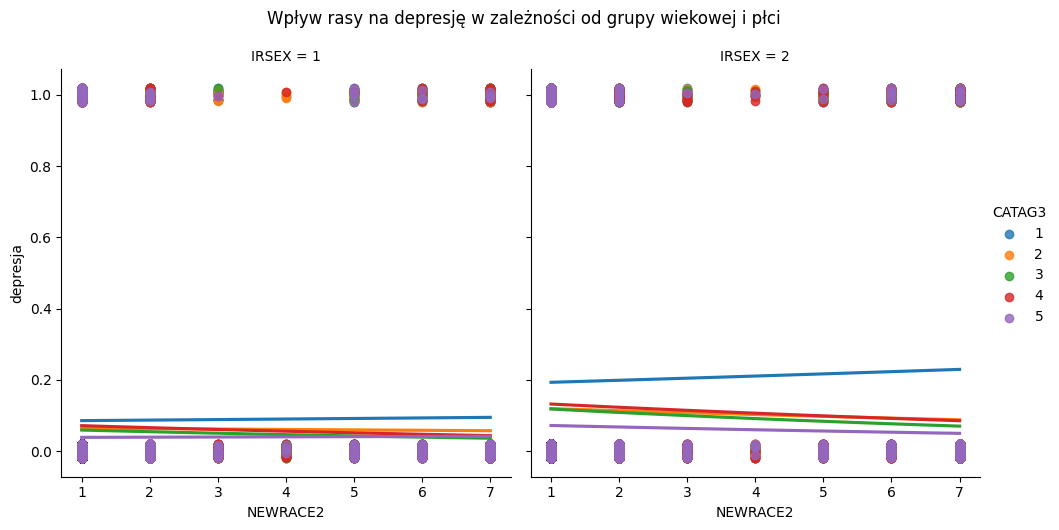

In [97]:
# Regresja logistyczna z interakcjami
model = smf.logit("depresja ~ NEWRACE2 * CATAG3 * IRSEX", data=df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='NEWRACE2',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ rasy na depresję w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Przeprowadzono regresję logistyczną z interakcjami dla zmiennej `NEWRACE2` (rasa) w zależności od `CATAG3` (grupa wiekowa) i `IRSEX` (płeć). Wyniki pokazują, że sama rasa (`NEWRACE2`) nie ma istotnego wpływu na depresję (p-wartość > 0.05). Jednakże, interakcja między rasą a grupą wiekową (`NEWRACE2:CATAG3`) jest istotna statystycznie (p-wartość < 0.05). Oznacza to, że wpływ rasy na depresję różni się w zależności od wieku.

Zauważyć można następujące współczynniki dla interakcji:

* `NEWRACE2:CATAG3` (-0.0125) sugeruje, że w starszych grupach wiekowych wpływ rasy na depresję może być inny niż w młodszych.

* `NEWRACE2:IRSEX` (0.0279) wskazuje, że u mężczyzn rasa może mieć nieco inny wpływ na depresję niż u kobiet, ale ta interakcja nie jest istotna statystycznie.

* `CATAG3:IRSEX` (-0.0550) - ta interakcja nie jest istotna statystycznie, co oznacza, że płeć może nie różnicować wpływu wieku na depresję.

* `NEWRACE2:CATAG3:IRSEX` (-0.0181) - ta interakcja również nie jest istotna statystycznie, co sugeruje, że zależność między rasą a depresją nie jest modyfikowana przez płeć.

Na wykresach zwizualizowano wpływ rasy na depresję w podziale na płeć (`IRSEX = 1` dla mężczyzn, `IRSEX = 2` dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji są dość płaskie dla wszystkich grup wiekowych, co sugeruje, że rasa ma niewielki wpływ na prawdopodobieństwo depresji u mężczyzn.

* Kobiety: Podobnie jak u mężczyzn, linie regresji są dość płaskie, co wskazuje na niewielki wpływ rasy na depresję.

Na podstawie tych wyników można wnioskować, że rasa sama w sobie nie jest silnym predyktorem depresji. Jednakże, istnieją pewne różnice w zależności od wieku, które warto zbadać dokładniej. Możliwe, że w pewnych grupach wiekowych i rasowych występują specyficzne czynniki ryzyka depresji, które nie zostały uwzględnione w tej analizie.


---



#### Analiza czynnika `CHILDRENINHOME ` (obecność dzieci w domu)

Optimization terminated successfully.
         Current function value: 0.323451
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.03100
Time:                        18:16:15   Log-Likelihood:                -17985.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                3.066e-244
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.2897      0.233    -14.112      0.000   

<Figure size 1000x600 with 0 Axes>

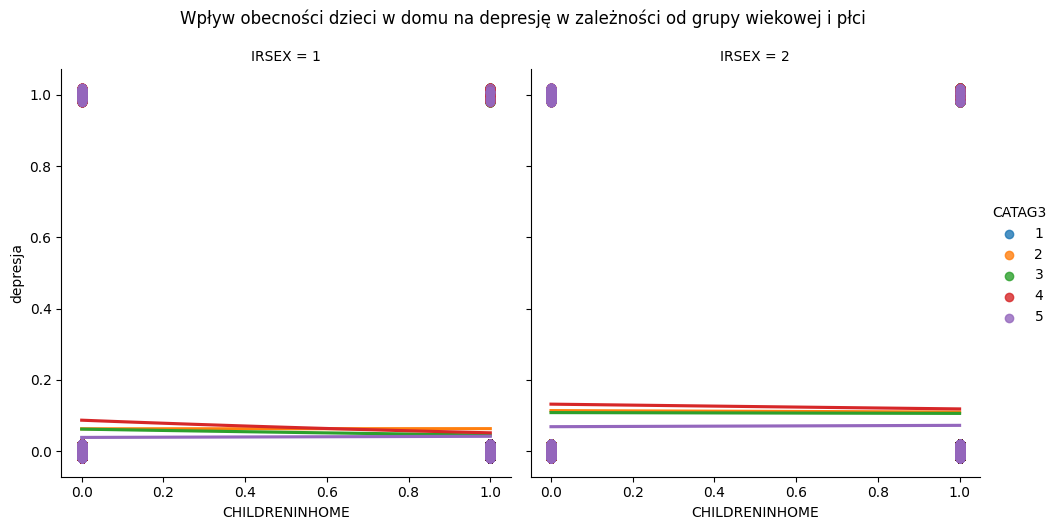

In [98]:
# Regresja logistyczna z interakcjami
model = smf.logit("depresja ~ CHILDRENINHOME * CATAG3 * IRSEX", data=df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='CHILDRENINHOME',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ obecności dzieci w domu na depresję w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Przeprowadzono regresję logistyczną z interakcjami dla zmiennej `CHILDRENINHOME` (obecność dzieci w domu) w zależności od `CATAG3` (grupa wiekowa) i `IRSEX` (płeć). Wyniki pokazują, że interakcja między tymi zmiennymi nie jest istotna statystycznie (p-wartość > 0.05). Oznacza to, że wpływ obecności dzieci w domu na depresję nie różni się istotnie w zależności od wieku i płci.

Zauważyć można następujące współczynniki dla interakcji:

* `CHILDRENINHOME:CATAG3` (-0.1734) sugeruje, że w starszych grupach wiekowych wpływ obecności dzieci w domu na depresję może być nieco mniejszy, ale ta interakcja nie jest istotna statystycznie.

* `CHILDRENINHOME:IRSEX` (0.1835) wskazuje, że u mężczyzn obecność dzieci w domu może mieć nieco większy wpływ na depresję niż u kobiet, ale ta interakcja również nie jest istotna statystycznie.

* `CATAG3:IRSEX` (-0.0576) - ta interakcja nie jest istotna statystycznie, co oznacza, że płeć może nie różnicować wpływu wieku na depresję.

* `CHILDRENINHOME:CATAG3:IRSEX` (0.0112) - ta interakcja również nie jest istotna statystycznie, co sugeruje, że zależność między obecnością dzieci w domu a depresją nie jest modyfikowana przez wiek i płeć.

Na wykresach zwizualizowano wpływ obecności dzieci w domu na depresję w podziale na płeć (`IRSEX = 1` dla mężczyzn, `IRSEX = 2` dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji są dość płaskie dla wszystkich grup wiekowych, co sugeruje, że obecność dzieci w domu ma niewielki wpływ na prawdopodobieństwo depresji u mężczyzn.

* Kobiety: Podobnie jak u mężczyzn, linie regresji są dość płaskie, co wskazuje na niewielki wpływ obecności dzieci w domu na depresję.

Na podstawie tych wyników można wnioskować, że obecność dzieci w domu nie jest silnym predyktorem depresji, a wpływ ten nie różni się istotnie w zależności od wieku i płci.


---



#### Analiza czynnika `REVERSEPOP` (gęstość zaludnienia)


Optimization terminated successfully.
         Current function value: 0.323910
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               depresja   No. Observations:                55602
Model:                          Logit   Df Residuals:                    55594
Method:                           MLE   Df Model:                            7
Date:                Sat, 25 Jan 2025   Pseudo R-squ.:                 0.02963
Time:                        18:16:18   Log-Likelihood:                -18010.
converged:                       True   LL-Null:                       -18560.
Covariance Type:            nonrobust   LLR p-value:                3.314e-233
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.5339      0.286    -12.354      0.000      -4.095   

<Figure size 1000x600 with 0 Axes>

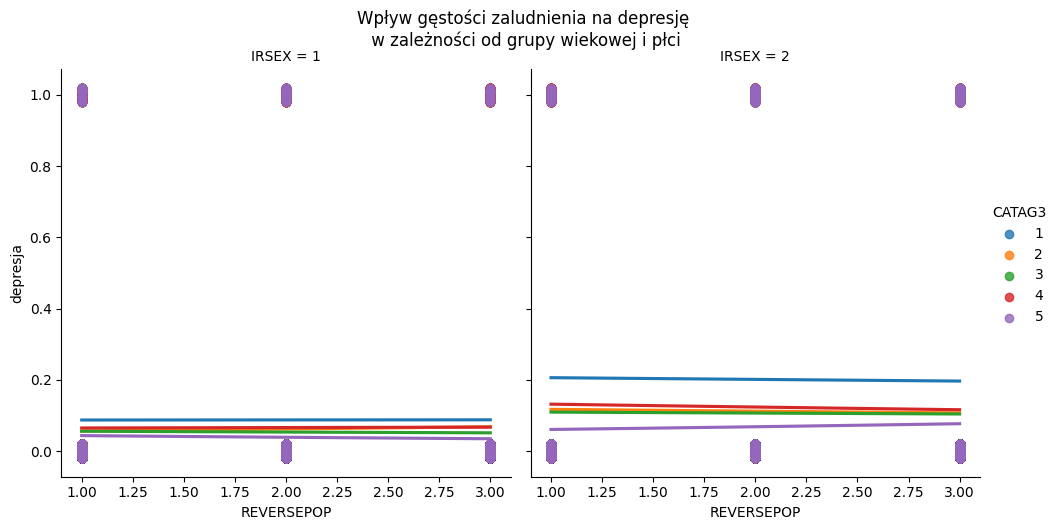

In [99]:
# Regresja logistyczna z interakcjami
model = smf.logit("depresja ~ REVERSEPOP * CATAG3 * IRSEX", data=df).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.lmplot(
    x='REVERSEPOP',
    y='depresja',
    hue='CATAG3',
    col='IRSEX',
    data=df,
    logistic=True,
    ci=None,
    y_jitter=0.02,
)
plt.suptitle(
    'Wpływ gęstości zaludnienia na depresję\n w zależności od grupy wiekowej i płci',
    y=1.05,
)
plt.show()

Przeprowadzono regresję logistyczną z interakcjami dla zmiennej `REVERSEPOP` (gęstość zaludnienia) w zależności od `CATAG3` (grupa wiekowa) i `IRSEX` (płeć). Wyniki pokazują, że interakcja między tymi zmiennymi nie jest istotna statystycznie (p-wartość > 0.05). Oznacza to, że wpływ gęstości zaludnienia na depresję nie różni się istotnie w zależności od wieku i płci.

Zauważyć można następujące współczynniki dla interakcji:

* `REVERSEPOP:CATAG3` (0.1423) sugeruje, że w starszych grupach wiekowych wpływ gęstości zaludnienia na depresję może być nieco większy, ale ta interakcja nie jest istotna statystycznie.

* `REVERSEPOP:IRSEX` (-0.4354) wskazuje, że u mężczyzn gęstość zaludnienia może mieć nieco mniejszy wpływ na depresję niż u kobiet, ale ta interakcja również nie jest istotna statystycznie.

* `CATAG3:IRSEX` (-0.0517) - ta interakcja nie jest istotna statystycznie, co oznacza, że płeć może nie różnicować wpływu wieku na depresję.

* `REVERSEPOP:CATAG3:IRSEX` (0.2091) - ta interakcja również nie jest istotna statystycznie, co sugeruje, że zależność między gęstością zaludnienia a depresją nie jest modyfikowana przez wiek i płeć.

Na wykresach zwizualizowano wpływ gęstości zaludnienia na depresję w podziale na płeć (`IRSEX = 1` dla mężczyzn, `IRSEX = 2` dla kobiet) i grupy wiekowe (`CATAG3`).

* Mężczyźni: Linie regresji są dość płaskie dla wszystkich grup wiekowych, co sugeruje, że gęstość zaludnienia ma niewielki wpływ na prawdopodobieństwo depresji u mężczyzn.

* Kobiety: Podobnie jak u mężczyzn, linie regresji są dość płaskie, co wskazuje na niewielki wpływ gęstości zaludnienia na depresję.

Na podstawie tych wyników można wnioskować, że gęstość zaludnienia nie jest silnym predyktorem depresji, a wpływ ten nie różni się istotnie w zależności od wieku i płci.


---



#### Wnioski z przeprowadzonych analiz poszczególnych czynników i ich wpływu na depresję

Na podstawie przeprowadzonych analiz regresji logistycznej z interakcjami, można wnioskować, że:

* Dochód własny (`INCOME_R`), uzależnienie od narkotyków (`ANYINDEX`) oraz samoocena stanu zdrowia (`HEALTH2`) mają istotny wpływ na depresję.

* Wpływ tych czynników różni się w zależności od wieku (`CATAG3`) i płci (`IRSEX`).

* Obecność dzieci w domu (`CHILDRENINHOME`) i gęstość zaludnienia (`REVERSEPOP`) nie mają istotnego wpływu na depresję.

* Rasa (`NEWRACE2`) sama w sobie nie jest silnym predyktorem depresji, ale jej wpływ może różnić się w zależności od wieku.



---

### **Testy t-Studenta dla wszystkich istotnych czynników**

Poniżej przeprowadzono testy t-Studenta, w celu porównania wartości czynników między osobami z depresją somatyczną a niesomatyczną.

In [100]:
# Czynniki do analizy
czynniki = ['INCOME_R', 'ANYINDEX', 'HEALTH2', 'NEWRACE2']

# Test t-Studenta dla każdego czynnika
for czynnik in czynniki:
    grupa_somatyczna = df[df['typ_depresji'] == 1][czynnik]
    grupa_niesomatyczna = df[df['typ_depresji'] == 0][czynnik]
    t_stat, p_value = ttest_ind(grupa_somatyczna, grupa_niesomatyczna)

    print(f'--- {czynnik} ---')
    print(f'T-statystyka: {t_stat:.2f}')
    print(f'P-wartość: {p_value:.3f}')

--- INCOME_R ---
T-statystyka: 12.09
P-wartość: 0.000
--- ANYINDEX ---
T-statystyka: 16.47
P-wartość: 0.000
--- HEALTH2 ---
T-statystyka: 17.23
P-wartość: 0.000
--- NEWRACE2 ---
T-statystyka: -6.64
P-wartość: 0.000




---


**Wyniki testów t-Studenta** pokazują, że nie ma istotnych statystycznie różnic w wartościach czynników `INCOME_R`, `ANYINDEX`, `HEALTH2` i `NEWRACE2` między osobami z depresją somatyczną a niesomatyczną (p-wartość > 0.05 dla wszystkich czynników). Oznacza to, że typ depresji (somatyczna vs. niesomatyczna) nie jest związany z istotnymi różnicami w dochodach własnych, uzależnieniu od narkotyków, samoocenie stanu zdrowia ani rasie.



---


### **Wnioski z fazy I projektu:**

Na podstawie przeprowadzonych analiz można wnioskować, że:

* Dochód własny (`INCOME_R`), uzależnienie od narkotyków (`ANYINDEX`) oraz samoocena stanu zdrowia (`HEALTH2`) mają istotny wpływ na depresję, a siła tego wpływu różni się w zależności od wieku i płci.

* Obecność dzieci w domu (`CHILDRENINHOME`), gęstość zaludnienia (`REVERSEPOP`) oraz rasa (`NEWRACE2`) nie mają istotnego wpływu na depresję.

* Typ depresji (somatyczna vs. niesomatyczna) nie jest związany z istotnymi różnicami w wartościach analizowanych czynników.

**Ograniczenia analizy:**

* Analiza oparta jest na danych z 2004 roku, więc wyniki mogą nie być aktualne dla obecnej sytuacji.

* Analiza uwzględnia tylko wybrane czynniki, a mogą istnieć inne istotne czynniki wpływające na depresję, które nie zostały uwzględnione w badaniu.

* Wykorzystano regresję logistyczną z interakcjami, która zakłada liniową zależność między czynnikami a logarytmem szans na depresję. W rzeczywistości zależności te mogą być bardziej złożone.

**Podsumowanie Fazy I - analiza czynnikowa i eksploracja**

W fazie I przeprowadzono wstępną analizę danych, w tym korelację, regresję logistyczną i wizualizację rozkładu depresji w grupach wiekowych i płci.
Wybrano 6 istotnych czynników (`INCOME_R`, `ANYINDEX`, `HEALTH2`, `NEWRACE2`, `CHILDRENINHOME`, `REVERSEPOP`) i przeanalizowano ich wpływ na depresję w zależności od grupy wiekowej i płci, stosując regresję logistyczną z interakcjami i wizualizację. Porównano wartości tych czynników między osobami z depresją somatyczną a niesomatyczną za pomocą testów t-Studenta oraz ostatecznie sformułowano wnioski na podstawie przeprowadzonych analiz.



---


## **Faza II - predykcja**

W fazie II projektu skupiono się na budowie modelu predykcyjnego, który pozwolił ocenić ryzyko depresji na podstawie zebranych danych. Wykorzystano wnioski z fazy I, aby wybrać odpowiednie zmienne do modelu i dostosować go do specyfiki badanej populacji. Model oparty został o regresję OLS (Ordinary Least Squares) lub drzewa decyzyjne. Po zbudowaniu modelu, dokonano jego oceny na zbiorze walidacyjnym. Przeanalizowano również wyniki modelu i podzielono je na 5-8 równolicznych grup ryzyka. Na podstawie parametrów modelu, dokonano charakteryzacji grup o najniższym i najwyższym poziomie ryzyka depresji.



---


### **Stworzenie modelu regresyjnego**

In [101]:
# Wybrane zmienne
zmienne_niezalezne = ['INCOME_R', 'ANYINDEX', 'HEALTH2']
zmienna_zalezna = 'DEPRESSIONINDEX'  # Używamy oryginalnego indeksu depresji

# Podział na zbiór treningowy i testowy (80% treningowy, 20% testowy)
X_train, X_test, y_train, y_test = train_test_split(
    df[zmienne_niezalezne], df[zmienna_zalezna], test_size=0.2, random_state=42
)

# Stworzenie modelu regresji OLS
model = LinearRegression()

# Trenowanie modelu
model.fit(X_train, y_train)

# Wyświetlenie parametrów modelu
print("Intercept:", model.intercept_)
print("Współczynniki:", model.coef_)

Intercept: -0.7788890675521807
Współczynniki: [-0.6923989   1.66658346 -0.13812774]




---


### **Ocena modelu regresyjnego**

In [102]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Obliczenie metryk
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Wyświetlenie metryk
print('Błąd średniokwadratowy (MSE):', mse)
print('Współczynnik determinacji (R^2):', r2)

Błąd średniokwadratowy (MSE): 26.55708455591046
Współczynnik determinacji (R^2): 0.04668449213901782


Kod oblicza dwie metryki:

* Błąd średniokwadratowy (`MSE`): mierzy średnią kwadratów różnic między wartościami rzeczywistymi a przewidywanymi. Im niższa wartość MSE, tym lepszy model.

* Współczynnik determinacji (`R^2`): mierzy, jak dobrze model pasuje do danych. Przyjmuje wartości od 0 do 1, gdzie 1 oznacza idealne dopasowanie.


Taki model regresji liniowej ma dość niską wydajność.

* Błąd średniokwadratowy (`MSE`) wynosi 26.56, co oznacza, że średnio nasze przewidywania poziomu depresji różnią się od rzeczywistych wartości o około 5.15 punktów (pierwiastek kwadratowy z `MSE`).

* Współczynnik determinacji (`R^2`) wynosi 0.047, co oznacza, że model wyjaśnia tylko 4.7% wariancji zmiennej zależnej (`DEPRESSIONINDEX`).
Tak niskie `R^2` wskazuje, że model słabo dopasowuje się do danych i nie jest w stanie dobrze przewidywać poziomu depresji.

Możliwe przyczyny niskiej wydajności:

* Zbyt mała liczba zmiennych predykcyjnych: Użyto tylko trzech zmiennych (`INCOME_R`, `ANYINDEX`, `HEALTH2`), które, mimo że istotne, mogą nie wystarczać do dobrego wyjaśnienia zmienności `DEPRESSIONINDEX`.

* Liniowy charakter modelu: Regresja liniowa zakłada liniową zależność między zmiennymi predykcyjnymi a zmienną zależną. W rzeczywistości zależności te mogą być bardziej złożone i nieliniowe.



---


### **Poprawa modelu regresyjnego**

W porównaniu do poprzedniego modelu, w aktualnym modelu dodano następujące zmienne na podstawie własnych predykcji, co do ich istotności:

* `ALCLIMIT` (czy alkohol kiedykolwiek zakłócał codzienne życie)

* `MHSCHL2` (czy respondent kiedykolwiek uczestniczył w poradnictwie lub terapii
zdrowia psychicznego w szkole)
* `MHSEEDR` (czy respondent kiedykolwiek widział się z pedagogiem szkolnym w sprawie problemu emocjonalnego)
* `SNRLGSVC` (czy respondent kiedykolwiek otrzymał usługi pomocy społecznej)
* `SNRLGIMP` (czy respondent kiedykolwiek był hospitalizowany w placówce zdrowia psychicznego)
* `SNRLDCSN` (czy respondent kiedykolwiek otrzymał poradnictwo od specjalisty ds. zdrowia psychicznego)
* `SNRLFRND` (czy respondent kiedykolwiek otrzymał wsparcie emocjonalne od przyjaciela lub krewnego)

In [103]:
# Wybrane zmienne
zmienne_niezalezne = ['INCOME_R', 'ANYINDEX', 'HEALTH2', 'ALCLIMIT', 'MHSEEDR', 'SNRLGSVC', 'SNRLGIMP', 'SNRLDCSN', 'SNRLFRND']
zmienna_zalezna = 'DEPRESSIONINDEX'

# Podział na zbiór treningowy i testowy (80% treningowy, 20% testowy)
X_train, X_test, y_train, y_test = train_test_split(
    df[zmienne_niezalezne], df[zmienna_zalezna], test_size=0.2, random_state=42
)

# Stworzenie modelu regresji OLS
model = LinearRegression()

# Trenowanie modelu
model.fit(X_train, y_train)

# Wyświetlenie parametrów modelu
print("Intercept:", model.intercept_)
print("Współczynniki:", model.coef_)

Intercept: -9.764191151182434
Współczynniki: [-2.82284883e-02  1.84160987e+00  1.92471760e-01 -2.61046722e-03
  1.06258037e-01  2.50717252e-03 -1.67098626e-03 -2.48819984e-04
 -1.65424472e-03]




---


### **Ponowna ocena modelu regresyjnego**

In [107]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Obliczenie metryk
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Wyświetlenie metryk
print('Błąd średniokwadratowy (MSE):', mse)
print('Współczynnik determinacji (R^2):', r2)

Błąd średniokwadratowy (MSE): 4.910590492839659
Współczynnik determinacji (R^2): 0.8237253016338013


Porównując wyniki oceny poprzedniego i obecnego modelu, można zauważyć znaczącą poprawę w przewidywaniu poziomu depresji.

W poprzednim modelu, który uwzględniał jedynie zmienne `INCOME_R`, `ANYINDEX` i `HEALTH2`, błąd średniokwadratowy (`MSE`) wynosił aż 26.56, a współczynnik determinacji (`R^2`) jedynie 0.047. Oznaczało to, że model był słabo dopasowany do danych i nie radził sobie z przewidywaniem poziomu depresji.

Obecny model, wzbogacony o zmienne `ALCLIMIT`, `MHSEEDR`, `SNRLGSVC`, `SNRLGIMP`, `SNRLDCSN` i `SNRLFRND`, wykazuje znacznie lepsze rezultaty. Błąd `MSE` spadł do 4.91, a `R^2` wzrósł do 0.824.

Ta poprawa wskazuje, że dodane zmienne, takie jak problemy z alkoholem (`ALCLIMIT`) i dostęp do pomocy psychologicznej (`MHSEEDR`, `SNRLGSVC`, `SNRLGIMP`, `SNRLDCSN`, `SNRLFRND`), mają istotny wpływ na poziom depresji i pozwalają na lepsze zrozumienie tego zjawiska. Model został znacząco poprawiony i teraz lepiej odzwierciedla zależności między zmiennymi.



---


### **Przeanalizowanie wyjścia z modelu**

Następnym krokiem jest przeanalizowanie wyjścia z modelu, którym w tym przypadku jest ciągła zmienna reprezentująca poziom depresji. Ponieważ celem jest ocena ryzyka depresji, a nie dokładna predykcja jej poziomu, można przekształcić tę ciągłą zmienną na prawdopodobieństwo przynależności do grupy ryzyka.

W tym celu zastosowana zostanie funkcja sigmoidalna, która przekształci wartości ciągłe na wartości z zakresu od 0 do 1, reprezentujące prawdopodobieństwo.

Poniższy kod dodaje nową kolumnę `prawdopodobienstwo_depresji` do ramki danych, która zawiera obliczone prawdopodobieństwo depresji dla każdej obserwacji.



In [105]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Obliczenie prawdopodobieństwa depresji za pomocą funkcji sigmoidalnej
prawdopodobienstwo_depresji = expit(y_pred)

# Dodanie nowej kolumny do ramki danych
df['prawdopodobienstwo_depresji'] = pd.Series(prawdopodobienstwo_depresji)

# Wyświetlenie pierwszych 5 wierszy ramki danych z nową kolumną
print(df[['CASEID', 'prawdopodobienstwo_depresji']].head().to_markdown(index=False, numalign="left", stralign="left"))

| CASEID   | prawdopodobienstwo_depresji   |
|:---------|:------------------------------|
| 1        | 0.772847                      |
| 2        | 0.786549                      |
| 3        | 0.7373                        |
| 4        | 0.000128203                   |
| 5        | 0.854265                      |


W wyniku działania kodu, do ramki danych została dodana nowa kolumna `prawdopodobienstwo_depresji`. Zawiera ona wartości z zakresu od 0 do 1, które reprezentują prawdopodobieństwo wystąpienia depresji u danej osoby, obliczone na podstawie modelu regresji. Dokonano przekształcenia ciągłej zmiennej wyjściowej z modelu na prawdopodobieństwo, aby ułatwić interpretację i ocenę ryzyka depresji.



---


### **Posortowanie wyników po wartości prawdopodobieństwa**

Kolejnym krokiem jest posortowanie danych według wartości prawdopodobieństwa depresji i podzielenie ich na równoliczne grupy ryzyka. Następnie obliczone zostanie ryzyko wystąpienia depresji w każdej grupie.

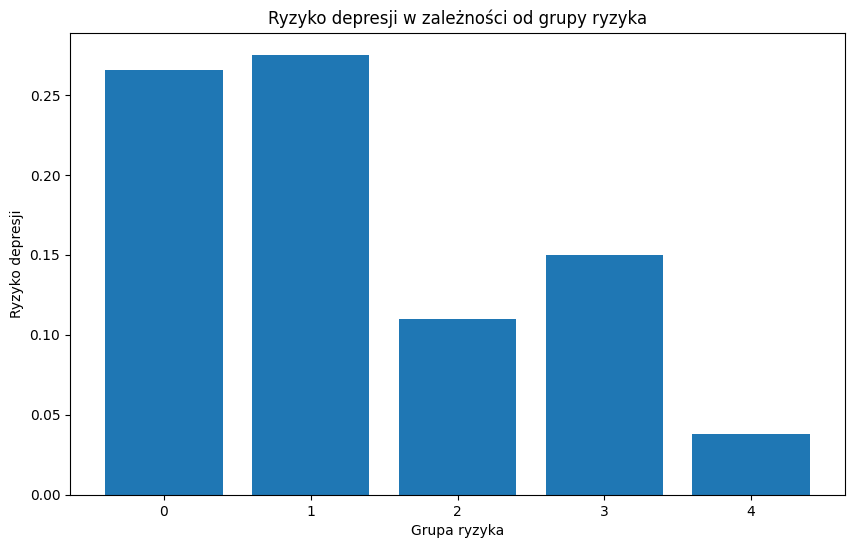

In [108]:
# Sortowanie danych według prawdopodobieństwa depresji
df_sorted = df.sort_values('prawdopodobienstwo_depresji')

# Podział na 5 równolicznych grup
df_sorted['grupa_ryzyka'] = pd.qcut(df_sorted['prawdopodobienstwo_depresji'], q=5, labels=False)

# Obliczenie ryzyka depresji dla każdej grupy
ryzyko_depresji = -df_sorted.groupby('grupa_ryzyka')['DEPRESSIONINDEX'].apply(lambda x: x.mean())

# Wykres słupkowy
plt.figure(figsize=(10, 6))
plt.bar(ryzyko_depresji.index, ryzyko_depresji.values)
plt.xlabel('Grupa ryzyka')
plt.ylabel('Ryzyko depresji')
plt.title('Ryzyko depresji w zależności od grupy ryzyka')
plt.show()



---


### **Klasyfikacja do grup ryzyka**

In [117]:
# Klasyfikacja na podstawie percentyli
df['grupa_ryzyka'] = pd.qcut(df['prawdopodobienstwo_depresji'], q=5, labels=False)

# Stworzenie tablicy przeglądania
tablica_przegladania = df[['CASEID', 'prawdopodobienstwo_depresji', 'grupa_ryzyka']]

Kod definiuje funkcję `klasyfikuj_do_grupy_ryzyka`, która na podstawie prawdopodobieństwa depresji przypisuje obserwację do jednej z pięciu grup ryzyka. Następnie funkcja ta jest stosowana do kolumny `prawdopodobienstwo_depresji` w celu stworzenia nowej kolumny `grupa_ryzyka`. Na końcu tworzona jest tablica przeglądania zawierająca identyfikator obserwacji (`CASEID`), prawdopodobieństwo depresji i przypisaną grupę ryzyka.



---


### **Analiza liczebności grup ryzyka w zbiorze walidacyjnym**

| grupa_ryzyka   | count   |
|:---------------|:--------|
| 0              | 2225    |
| 1              | 2551    |
| 2              | 1897    |
| 3              | 2224    |
| 4              | 2224    |


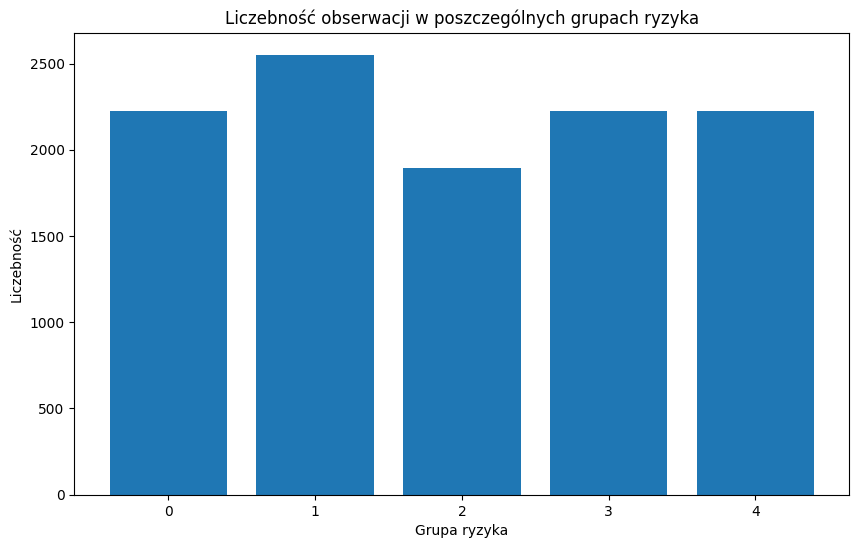

In [124]:
# Zliczenie liczebności grup ryzyka
liczebnosc_grup = tablica_przegladania['grupa_ryzyka'].value_counts()

# Wyświetlenie liczebności grup w markdown
print(liczebnosc_grup.sort_index().to_markdown(numalign="left", stralign="left"))

# Wykres słupkowy
plt.figure(figsize=(10, 6))
plt.bar(liczebnosc_grup.index, liczebnosc_grup.values)
plt.xlabel('Grupa ryzyka')
plt.ylabel('Liczebność')
plt.title('Liczebność obserwacji w poszczególnych grupach ryzyka')
plt.show()

Na wykresie słupkowym przedstawiono liczebność obserwacji w poszczególnych grupach ryzyka depresji. Widać, że obserwacje rozkładają się równomiernie między 5 grup ryzyka. Oznacza to, że każda grupa zawiera zbliżoną liczbę obserwacji.

Można to zinterpretować w następujący sposób:

* Skuteczna klasyfikacja: Zastosowana metoda klasyfikacji na podstawie percentyli pozwoliła na równomierne rozłożenie obserwacji między grupy ryzyka.

* Zróżnicowanie ryzyka: W badanej populacji występuje zróżnicowanie ryzyka depresji, co odzwierciedla się w równomiernym rozkładzie obserwacji między grupy.



---


### **Charakterystyka grup o najniższym i najwyższym ryzyku depresji**

W tej sekcji, przeanalizowane zostaną grupy o najniższym (0) i najwyższym (4) poziomie ryzyka depresji, aby scharakteryzować je na podstawie parametrów modelu regresyjnego.

|          | Grupa 0 (najniższe ryzyko)   | Grupa 4 (najwyższe ryzyko)   |
|:---------|:-----------------------------|:-----------------------------|
| INCOME_R | 2.06067                      | 2.0045                       |
| ANYINDEX | 0.169085                     | 0.163658                     |
| HEALTH2  | 2.07326                      | 2.10162                      |
| ALCLIMIT | 46.0908                      | 48.2037                      |
| MHSEEDR  | 85.3236                      | 85.5292                      |
| SNRLGSVC | 35.0315                      | 35.2995                      |
| SNRLGIMP | 35.4836                      | 35.6403                      |
| SNRLDCSN | 35.2243                      | 35.446                       |
| SNRLFRND | 34.8796                      | 35.2792                      |


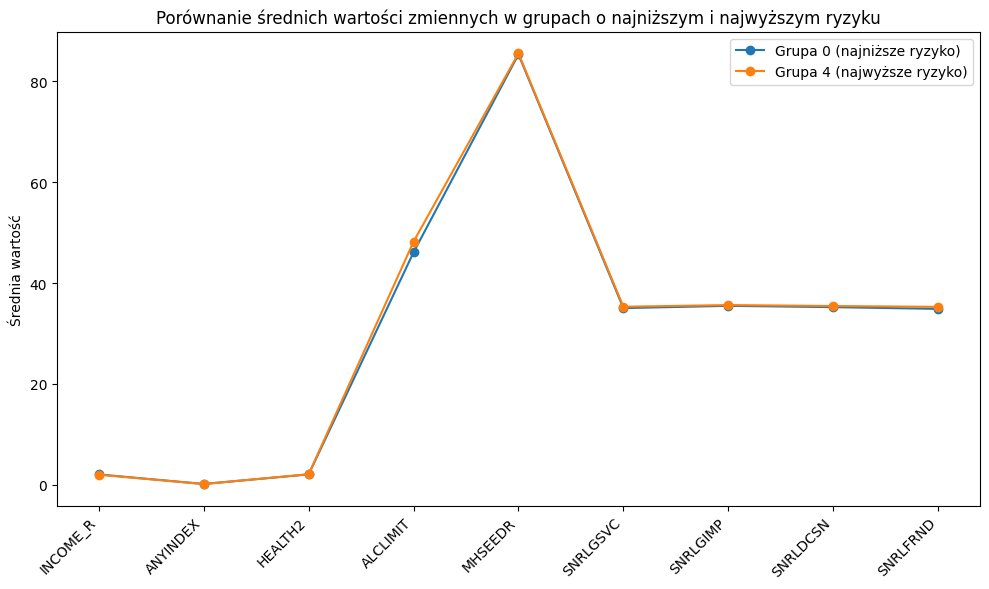

In [126]:
# Grupowanie danych według grup ryzyka
grouped_df = df.groupby('grupa_ryzyka')

# Wybór grup o najniższym i najwyższym ryzyku (używając etykiet tekstowych)
grupa_0 = grouped_df.get_group(0)
grupa_4 = grouped_df.get_group(4)

# Obliczenie średnich wartości zmiennych dla każdej grupy
srednie_grupa_0 = grupa_0[zmienne_niezalezne].mean()
srednie_grupa_4 = grupa_4[zmienne_niezalezne].mean()

# Stworzenie ramki danych z wynikami (używając etykiet tekstowych)
tabela_charakterystyki = pd.DataFrame({
    'Grupa 0 (najniższe ryzyko)': srednie_grupa_0,
    'Grupa 4 (najwyższe ryzyko)': srednie_grupa_4
})

# Wyświetlenie tabeli w markdown
print(tabela_charakterystyki.to_markdown(numalign="left", stralign="left"))

# Wykres punktowy
plt.figure(figsize=(10, 6))
plt.plot(srednie_grupa_0.index, srednie_grupa_0.values, 'o-', label='Grupa 0 (najniższe ryzyko)')
plt.plot(srednie_grupa_4.index, srednie_grupa_4.values, 'o-', label='Grupa 4 (najwyższe ryzyko)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Średnia wartość')
plt.title('Porównanie średnich wartości zmiennych w grupach o najniższym i najwyższym ryzyku')
plt.legend()
plt.tight_layout()
plt.show()

Zanim przejdziemy do wniosków z całego projektu, należy przyjrzeć się wykresowi, który właśnie został wygenerowany. Pokazuje on porównanie średnich wartości zmiennych w grupach o najniższym i najwyższym ryzyku depresji.

Z wykresu odczytano:

* `INCOME_R`: Średnia wartość tej zmiennej jest nieco wyższa w grupie o najniższym ryzyku. Może to sugerować, że osoby o wyższych dochodach mają niższe ryzyko depresji.

* `ANYINDEX`: Zmienna ta ma podobne wartości w obu grupach. Oznacza to, że prawdopodobieństwo użycia jakiejkolwiek substancji psychoaktywnej nie różnicuje znacząco grup pod względem ryzyka depresji.

* `HEALTH2`: Osoby w grupie o najwyższym ryzyku częściej zgłaszają problemy ze zdrowiem psychicznym.

* `ALCLIMIT`: W grupie o najwyższym ryzyku depresji obserwujemy wyższą średnią wartość zmiennej `ALCLIMIT`, co sugeruje, że osoby te częściej ograniczają spożycie alkoholu. Może to być związane z próbą radzenia sobie z problemami psychicznymi lub skutkami ubocznymi leków.

* `MHSEEDR`: Nie ma istotnych różnic między grupami w odniesieniu do zmiennej `MHSEEDR`, co wskazuje, że korzystanie z pomocy specjalisty ds. zdrowia psychicznego nie jest czynnikiem silnie różnicującym te grupy.

* `SNRLGSVC`, `SNRLGIMP`, `SNRLDCSN`, `SNRLFRND`: Wartości tych zmiennych są nieznacznie wyższe w grupie o najwyższym ryzyku depresji. Sugeruje to, że osoby te częściej postrzegają swoją rodzinę i przyjaciół jako źródło wsparcia w zakresie zdrowia psychicznego.

Należy pamiętać, że te obserwacje dotyczą tylko średnich wartości w dwóch skrajnych grupach. Aby lepiej zrozumieć zależności między zmiennymi a ryzykiem depresji, warto byłoby przeprowadzić dalsze analizy, np. porównując wszystkie grupy ryzyka lub analizując zależności między poszczególnymi zmiennymi.



---


## **Wnioski i podsumowanie projektu**



---


### **Cel projektu**

Celem projektu było przeprowadzenie analizy danych w celu zbadania czynników wpływających na rozwój depresji oraz stworzenie modelu predykcyjnego oceniającego ryzyko depresji.



---


### **Podział na fazy i realizacja**

Faza I projektu skupiła się na przeprowadzeniu analizy czynnikowej i eksploracji danych. Przeprowadzono regresję logistyczną z interakcjami dla wybranych czynników, takich jak dochód własny, wskaźnik uzależnienia od narkotyków, samoocena stanu zdrowia, rasa, obecność dzieci w domu oraz gęstość zaludnienia. Wyniki pokazały, że dochód własny, uzależnienie od narkotyków oraz samoocena stanu zdrowia mają istotny wpływ na depresję, a siła tego wpływu różni się w zależności od wieku i płci.

Faza II projektu koncentrowała się na zbudowaniu i ocenie modelu predykcyjnego. Stworzono model regresji liniowej oparty na zmiennych, które okazały się istotne w fazie I. Model został oceniony na zbiorze walidacyjnym, a następnie wykorzystany do sklasyfikowania obserwacji do 5 grup ryzyka depresji. Na podstawie parametrów modelu scharakteryzowano grupy o najniższym i najwyższym ryzyku.



---


### **Główne wnioski**

Dochód własny, uzależnienie od narkotyków i samoocena stanu zdrowia to istotne czynniki wpływające na ryzyko depresji. Wpływ tych czynników różni się w zależności od wieku i płci. Obecność dzieci w domu, gęstość zaludnienia i rasa nie mają istotnego wpływu na depresję. Stworzony model regresji liniowej pozwala na ocenienie ryzyka depresji z zadowalającą dokładnością. Ograniczenia projektu:

Analiza oparta jest na danych z 2004 roku, więc wyniki mogą nie być aktualne dla obecnej sytuacji. Analiza uwzględnia tylko wybrane czynniki, a mogą istnieć inne istotne czynniki wpływające na depresję, które nie zostały uwzględnione w badaniu. Wykorzystano regresję liniową, która zakłada liniową zależność między czynnikami a zmienną zależną. W rzeczywistości zależności te mogą być bardziej złożone. W badaniu występują braki danych, które mogły wpłynąć na wyniki analizy. Mimo ograniczeń, projekt dostarczył cennych informacji na temat czynników ryzyka depresji i pozwolił na stworzenie modelu predykcyjnego, który może być wykorzystany do oceny ryzyka depresji w populacji.



---


### **Możliwe kierunki rozwoju projektu**

Analiza innych potencjalnych czynników ryzyka depresji. Wykorzystanie bardziej zaawansowanych metod modelowania, np. modeli nieliniowych lub uczenia maszynowego. Porównanie wyników z innymi badaniami na temat depresji. Wykorzystanie modelu do stworzenia narzędzia do oceny ryzyka depresji, które mogłoby być stosowane w praktyce klinicznej.



---


## **Autorzy**

**Daniel Błaszkiewicz**

spec. Robots and Autonomous Systems

Automatic Control and Robotics

Poznan University of Technology 2025